# Environment settings

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import random
from feret_utils import get_feret_files_and_tags_dict, run_face_detection, create_dataset, create_dataset_gs
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plot
from IPython.display import Image
import cv2 as cv
import tensorflow as tf
import scipy
from datetime import datetime
import pickle
tfe = tf.contrib.eager

In [2]:
# Set tf basic settings
print(tf.__version__)
tf.logging.set_verbosity(tf.logging.INFO)
tf.enable_eager_execution()

1.12.0


# Import precreated pickle file with dataset info

In [3]:
import pickle
# Unpickle data_dict holding the training and evaluation examples after performing data augmentation and regulerization
with open('feret_data_dict_gs.pickle', 'rb') as handle:
    subject_list, data_dict, mean_image, std_image = pickle.load(handle)

# Class to manage dataset minibatch structures for comparisson test

In [4]:
# One of the main issues in training this dataset for similarity between faces is that choosing random image "couples" for
# comparison leads to most training batches having an average of ~1.5 similar "couples". And even worse, in many cases all
# examples are of different "couples" which leads to an aggrssive training towards scoring big differences.
# This class ensures having a higher rate of similars by radndommly choosing near by photos within the dataset.
class Dataset():
    def __init__(self, X_train, y_train, batch_size=100, num_of_epochs=10):
        self.batch_size = batch_size - (batch_size % 2)
        self.num_of_epochs = num_of_epochs
        self.X_train = X_train
        self.y_train = y_train
        
        # Hold a list of training examples we have not used yet which will be modified every time an example is used
        self.unused_y = list(range(len(y_train)))
        self.steps = int((X_train.shape[0] * self.num_of_epochs) / self.batch_size)
    
    def create_mini_batch(self):
        mini_X_train = np.zeros((self.batch_size, 96, 96, 1), dtype=np.float32)
        mini_y_train = np.zeros((self.batch_size))
        
        # Verify there are enough examples left in dataset to fill minibatch, if not reset list of unused examples
        if len(self.unused_y) < self.batch_size:
            self.unused_y = list(range(len(self.y_train)))
        half_batch = int(self.batch_size/2)
        for i in range(half_batch):
            chosen = False
            count = 0
            while(not chosen):
                if (count == 30):
                    self.unused_y = list(range(len(self.y_train)))
                if (i % 2 == 0):
                    pos = random.choice(self.unused_y)
                    mini_X_train[i] = self.X_train[pos]
                    mini_y_train[i] = self.y_train[pos]
                    pos2 = random.choice(self.unused_y)
                    if (self.y_train[pos] != self.y_train[pos2]):
                        mini_X_train[i+half_batch] = self.X_train[pos2]
                        mini_y_train[i+half_batch] = self.y_train[pos2]
                        chosen = True
                    else:
                        count += 1
                else:
                    pos = random.choice(self.unused_y)
                    mini_X_train[i] = self.X_train[pos]
                    mini_y_train[i] = self.y_train[pos]
                    if (pos != 6930) and (self.y_train[pos] == self.y_train[pos+1]):
                        mini_X_train[i+half_batch] = self.X_train[pos+1]
                        mini_y_train[i+half_batch] = self.y_train[pos+1]
                        chosen = True
                    elif (pos != 0) and (self.y_train[pos] == self.y_train[pos-1]):
                        mini_X_train[i+half_batch] = self.X_train[pos-1]
                        mini_y_train[i+half_batch] = self.y_train[pos-1]
                        chosen = True
                    else:
                        count += 1
            
            # Once we used an exqmple, remove it from the 
            self.unused_y.remove(pos)
        return mini_X_train, mini_y_train

# Classifier model working with 2 steps of training, classification and contrastive. The model will then be used to extract a feature layer which will be compared with other layers.

In [5]:
class CombinedClassifier(tf.keras.Model):
    def __init__(self, num_of_ids, loss_type="Class", similarity_threshold=5, class_lr=0.5*1e-4, sim_lr=1e-3):
        super().__init__()
        self.loss_type = loss_type
        self.similarity_threshold = similarity_threshold
        self.num_of_ids = num_of_ids
        self.flag_for_combined_loss = False
        
        # Conv layer 1 + Pooling
        self.conv1a = tf.keras.layers.Conv2D(filters=32,
                                            kernel_size=[4, 4],
                                            strides=(1, 1),
                                            padding='same',
                                            activation=tf.nn.leaky_relu,
                                            use_bias=True,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                           )
        
        self.pool1a = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Conv layer 2 + Pooling
        self.conv2a = tf.keras.layers.Conv2D(filters=16,
                                            kernel_size=[3, 3],
                                            strides=(1, 1),
                                            padding='same',
                                            activation=tf.nn.leaky_relu,
                                            use_bias=True,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                           )
        
        self.pool2a = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Conv layer 3 + Pooling
        self.conv3a = tf.keras.layers.Conv2D(filters=16,
                                            kernel_size=[3, 3],
                                            strides=(1, 1),
                                            padding='same',
                                            activation=tf.nn.leaky_relu,
                                            use_bias=True,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                           )
        
        self.pool3a = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Dense output layer, also used as a feature exxtrction layer
        self.fc1a = tf.keras.layers.Dense(512, activation=None)
        self.fc1a_act = tf.keras.layers.Activation(activation=tf.nn.relu)
        
        # Dropout layer
        self.dropout = tf.keras.layers.Dropout(rate=0.2)
        
        # Dense layer for classes
        self.fc2a = tf.keras.layers.Dense(num_of_ids)
        
        # Optimizers
        self.optimizer1 = tf.train.AdamOptimizer(learning_rate=class_lr)
        self.optimizer2 = tf.train.AdamOptimizer(learning_rate=sim_lr, beta1=0.85)
        
    def call(self, inputs, training=True, **kwargs):
        half_batch_size = int(int(inputs.shape[0]) / 2)
        batch_size = int(half_batch_size * 2)
        
        # Input Layer
        input_layer = tf.reshape(inputs, [-1, 96, 96, 1])
        
        # Network forward flow
        x1 = self.conv1a(input_layer)
        x1 = self.pool1a(x1)
        x1 = self.conv2a(x1)
        x1 = self.pool2a(x1)
        x1 = self.conv3a(x1)
        x1 = self.pool3a(x1)
        x1 = tf.reshape(x1, [x1.shape[0], -1])
        x1_id_layer = self.fc1a(x1)
        x1_id_layer_act = self.fc1a_act(x1_id_layer)
        
        # If we are training for classification loss, use dropout.
        if (training):
            if self.loss_type is "Class":
                x1_dropout = self.dropout(x1_id_layer_act)
                x1_logits = self.fc2a(x1_dropout)
            else:
                x1_logits = self.fc2a(x1_id_layer_act)
                
            # Get L2 distances between image "couples"
            distances = tf.reduce_mean((x1_id_layer[0:half_batch_size] - x1_id_layer[half_batch_size:batch_size])**2, axis=1)

        else:
            x1_logits = self.fc2a(x1_id_layer_act)
            distances = 0

        
        return x1_logits, x1_id_layer, distances 
    
    def loss(self, logits1, labels1, x1_id_layer, batch_size):        
        half_batch_size = int(batch_size / 2)
        
        # Just to make sure that both halves are equal
        batch_size = int(half_batch_size * 2)
        
        # Calculate losses according to classification requirments and comparison requirement
        # Loss 1: classification requirement
        onehot_labels = tf.one_hot(indices=tf.cast(labels1, tf.int32), depth = num_of_ids)
        loss_1 = tf.losses.softmax_cross_entropy(onehot_labels, logits1)
            
        # Loss 2: contrastive loss
        gt_labels = np.zeros((half_batch_size))
        same = np.where(np.array(labels1[0:half_batch_size] - labels1[half_batch_size:batch_size]) == 0)[0]
        gt_labels[same] = 1
        gt_labels = tf.convert_to_tensor(gt_labels)
        
        anchors = tf.convert_to_tensor(x1_id_layer[0:half_batch_size])
        positives = tf.convert_to_tensor(x1_id_layer[half_batch_size:batch_size])
        loss_2 = tf.contrib.losses.metric_learning.contrastive_loss(labels=gt_labels,
                                                                    embeddings_anchor=anchors,
                                                                    embeddings_positive=positives,
                                                                    margin=self.similarity_threshold)
        return loss_1, loss_2
    
    def optimize(self, inputs, labels):
        with tf.GradientTape(persistent=True) as tape:
            x1_logits, x1_id_layer, distances = self(inputs)
            loss_1, loss_2 = self.loss(x1_logits, labels, x1_id_layer, int(inputs.shape[0]))
        
        # Apply gradinets according totraining phase we are in
        if self.loss_type is "Class":
            gradients = tape.gradient(loss_1, self.variables)
            self.optimizer1.apply_gradients(zip(gradients, self.variables))
        if self.loss_type is "Similarity":
            # For similarity training apply gradients only to the fc1a layer
            gradients = tape.gradient(loss_2, self.variables[6:8])
            self.optimizer2.apply_gradients(zip(gradients, self.variables[6:8]))
            
        del(tape)
        return loss_1, loss_2
    
    def test(self, inputs, labels, similarity_test=False, training_set=False, debug_print=False, thresh=1):
        x1_logits, x1_id_layer, distance = self(inputs, training=False)
        test_class_1, test_class_2, test_compare = 0, 0, 0
        
        # Scores for predecting image labels
        pred_labels = tf.argmax(x1_logits, axis=-1)
        pred_labels = tf.cast(pred_labels, tf.float64)
        label_acc = tf.reduce_mean(tf.cast(tf.equal(pred_labels, labels), tf.float32))
        
        # Scores for the similarity test
        correct, incorrect = 0, 0
        similarity_acc = 0
        sum_of_distances_for_sim, sum_of_distances_for_diff, sim_count, diff_count = 0, 0, 0, 0
        sim_diff_ratio = 0
        
        size = int(inputs.shape[0]) if (int(inputs.shape[0]) % 2 == 0) else int(inputs.shape[0]) - 1
        
        if (similarity_test):
            # Training and validation set have different structures so testing method is split into 2 options
            if (training_set):
                for i in range(0, int(size/2)):
                    if int(labels[i]) == int(labels[int(size/2) + i]):
                        if (tf.reduce_mean(tf.abs((x1_id_layer[i] - x1_id_layer[int(size/2) + i])**2))) < thresh:
                            correct +=1
                        else:
                            incorrect +=1
                    else:
                        if (tf.reduce_mean(tf.abs((x1_id_layer[i] - x1_id_layer[int(size/2) + i])**2))) > thresh:
                            correct +=1
                        else:
                            incorrect +=1
            else:
                for i in range(0, size, 2):
                    if int(labels[i]) == int(labels[i + 1]):
                        distance = tf.reduce_mean(tf.abs((x1_id_layer[i] - x1_id_layer[i + 1])**2))
                        sum_of_distances_for_sim += distance
                        sim_count += 1
                        if distance < thresh:
                            if(debug_print):
                                print("Got similar pics correct: distance = {} thresh = {}".format(distance, thresh))
                            correct +=1
                        else:
                            if(debug_print):
                                print("Got similar pics wrong: distance = {} thresh = {}".format(distance, thresh))
                            incorrect +=1
                    else:
                        distance = tf.reduce_mean(tf.abs((x1_id_layer[i] - x1_id_layer[i + 1])**2))
                        sum_of_distances_for_diff += distance
                        diff_count += 1
                        if distance > thresh:
                            if(debug_print):
                                print("Got different pics correct: distance = {} thresh = {}".format(distance, thresh))
                            correct +=1
                        else:
                            if(debug_print):
                                print("Got different pics wrong: distance = {} thresh = {}".format(distance, thresh))
                            incorrect +=1
                            
                distance_average_sim = sum_of_distances_for_sim/sim_count
                distance_average_diff = sum_of_distances_for_diff/diff_count
                # sim_diff_ratio is the ration of differences between distances predicted for similar pairs and the 
                # distacnes predicted for different pairs. The lower the difference the better the model will differ between
                # similar and different images
                sim_diff_ratio = distance_average_sim/distance_average_diff
                            
            # similarity_acc is the percantage of correct predictions
            similarity_acc = correct/(correct + incorrect)
            
            
        return label_acc, similarity_acc, sim_diff_ratio
        


# Phase 1: Train using classification loss

In [9]:
num_of_ids = len(subject_list)
# Metrics to save
loss1_val = []
loss_step = []
acc_val = []
acc_train = []
evaluation_step = []
best_score = 0

# Globals affecting logging and evaluation frequency
STEP_SIZE_LOSS = 40
STEP_SIZE_EVALUATE = 80

batch_size = 800
num_of_epochs = 40

dataset = Dataset(data_dict['X_train'], data_dict['y_train'], batch_size, num_of_epochs)
with tf.device("/device:GPU:0"):
    model = CombinedClassifier(num_of_ids=num_of_ids, loss_type="Class", class_lr=1e-3)
    for step in range(dataset.steps):
        batch_x, batch_y = dataset.create_mini_batch()
        if (step % STEP_SIZE_EVALUATE == 0 and step):
            
            # Evaluate on validation set
            accuracy, _, _ = model.test(data_dict['X_eval'], data_dict['y_eval'], similarity_test=False)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "EVAL SET: Step %d: classification accuracy: %f" % (step, accuracy)))
            acc_val.append(accuracy)
            evaluation_step.append(step)
            if (accuracy > best_score):
                model.save_weights('cpt/cpt_%s' % step)
                name_save = ('cpt/cpt_%s' % step)
                bestt_score = accuracy
            
            # Evaluate on training set
            accuracy, _, _ = model.test(batch_x, batch_y, similarity_test=False)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "TRAIN SET: Step %d: classification accuracy: %f" % (step, accuracy)))
            acc_train.append(accuracy)
            
        # Train
        loss1, loss2 = model.optimize(batch_x, batch_y)
        loss1_val.append(loss1)
        loss_step.append(step)
        
        if (step % STEP_SIZE_LOSS == 0):
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "Step %d: classification loss: %f" % (step, loss1)))
        

[29.12|19:38:20] Step 0: classification loss: 6.558256
[29.12|19:38:40] Step 40: classification loss: 2.896908
[29.12|19:39:00] EVAL SET: Step 80: classification accuracy: 0.570895
[29.12|19:39:00] TRAIN SET: Step 80: classification accuracy: 0.935000
[29.12|19:39:00] Step 80: classification loss: 0.234879
[29.12|19:39:21] Step 120: classification loss: 0.047964
[29.12|19:39:41] EVAL SET: Step 160: classification accuracy: 0.705224
[29.12|19:39:41] TRAIN SET: Step 160: classification accuracy: 0.998750
[29.12|19:39:41] Step 160: classification loss: 0.003206
[29.12|19:40:01] Step 200: classification loss: 0.004737
[29.12|19:40:21] EVAL SET: Step 240: classification accuracy: 0.705224
[29.12|19:40:21] TRAIN SET: Step 240: classification accuracy: 0.998750
[29.12|19:40:21] Step 240: classification loss: 0.001530
[29.12|19:40:42] Step 280: classification loss: 0.000266
[29.12|19:41:02] EVAL SET: Step 320: classification accuracy: 0.712687
[29.12|19:41:02] TRAIN SET: Step 320: classificati

## Classification loss

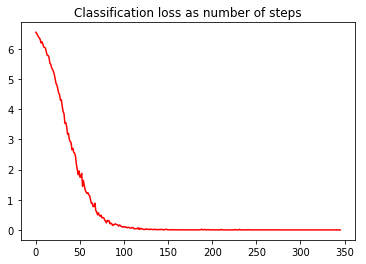

In [10]:
plot.title('Classification loss as number of steps')
plot.plot(loss_step, loss1_val, 'r')
plot.show()

## Classification accuracy

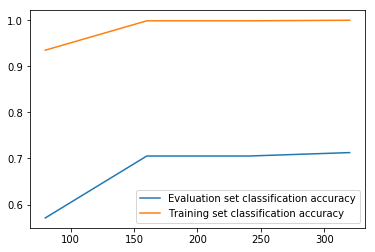

In [11]:
plot.plot(evaluation_step, acc_val, label='Evaluation set classification accuracy')
plot.plot(evaluation_step, acc_train, label='Training set classification accuracy')
plot.legend()
plot.show()

In [12]:
def get_best_score(model):
    best_sim=0
    threshs = np.arange(0, model.similarity_threshold, model.similarity_threshold/200)
    for i in threshs:
        accuracy, sim, _ = model.test(data_dict['X_eval'], data_dict['y_eval'], similarity_test=True, thresh=i)
        if (sim > best_sim):
            best_sim = sim
            best_thresh = i
    return (best_sim, best_thresh)

# Phase 2: train using contrastive loss

## Train with contrastive loss, margin=10

In [ ]:
num_of_ids = len(subject_list)

#Metrics to save
loss1_val = []
loss2_val = []
loss_step = []
acc_val = []
sim_val = []
acc_train = []
sim_train = []
evaluation_step = []

# Globals affecting logging and evaluation frequency
STEP_SIZE_LOSS = 500
STEP_SIZE_EVALUATE = 3000
best_sim = 0

batch_size = 128
num_of_epochs = 400
dataset = Dataset(data_dict['X_train'], data_dict['y_train'], batch_size, num_of_epochs)
with tf.device("/device:GPU:0"):
    model = CombinedClassifier(num_of_ids=num_of_ids, loss_type="Similarity", similarity_threshold=10, sim_lr=1e-3)
    model.load_weights(name_save)
    
    for step in range(dataset.steps):
        batch_x, batch_y = dataset.create_mini_batch()
        if (step % STEP_SIZE_EVALUATE == 0 and step != 0):          
            # Evaluate on validation set
            sim, th = get_best_score(model)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "EVAL SET: Step %d: similarity accuracy: %f" % (step, sim)))
            
            sim_val.append(sim)
            evaluation_step.append(step)
            if (sim > best_sim):
                model.save_weights('cpt/cpt_sim_contrastive_10')
                best_sim = sim
                best_thresh = th
            
            # Evaluate on training set
            accuracy, sim, _ = model.test(batch_x, batch_y, similarity_test=True, training_set=True)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "TRAIN SET: Step %d: similarity accuracy: %f" % (step, sim)))
            acc_train.append(accuracy)
            sim_train.append(sim)
            
            
        
        loss1, loss2 = model.optimize(batch_x, batch_y)
        loss1_val.append(loss1)
        loss2_val.append(loss2)
        loss_step.append(step)
        
        if (step % STEP_SIZE_LOSS == 0):
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "Step %d: Contrastive loss: %f" % (step, loss2)))


[29.12|19:41:57] Step 0: Contrastive loss: 25974.734375
[29.12|19:42:41] Step 500: Contrastive loss: 259.208801
[29.12|19:43:24] Step 1000: Contrastive loss: 128.267212
[29.12|19:44:08] Step 1500: Contrastive loss: 91.371742
[29.12|19:44:52] Step 2000: Contrastive loss: 104.051086
[29.12|19:45:36] Step 2500: Contrastive loss: 108.383736
[29.12|19:46:56] EVAL SET: Step 3000: similarity accuracy: 0.694030
[29.12|19:46:57] TRAIN SET: Step 3000: similarity accuracy: 0.531250
[29.12|19:46:57] Step 3000: Contrastive loss: 141.138290
[29.12|19:47:41] Step 3500: Contrastive loss: 117.171143
[29.12|19:48:24] Step 4000: Contrastive loss: 199.419983
[29.12|19:49:08] Step 4500: Contrastive loss: 88.135986
[29.12|19:49:52] Step 5000: Contrastive loss: 120.697769
[29.12|19:50:36] Step 5500: Contrastive loss: 91.447296
[29.12|19:51:56] EVAL SET: Step 6000: similarity accuracy: 0.701493
[29.12|19:51:57] TRAIN SET: Step 6000: similarity accuracy: 0.593750
[29.12|19:51:57] Step 6000: Contrastive loss: 9

## Contrastive Loss 

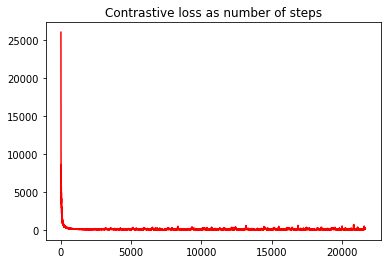

In [16]:
plot.title('Contrastive loss as number of steps')
plot.plot(loss_step, loss2_val, 'r')
plot.show()

## Evaluation for similarity check

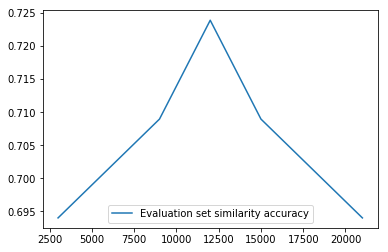

In [17]:
plot.plot(evaluation_step, sim_val, label='Evaluation set similarity accuracy')
plot.legend()
plot.show()

## Train with contrastive loss, margin=30

In [19]:
num_of_ids = len(subject_list)

#Metrics to save
loss1_val = []
loss2_val = []
loss_step = []
acc_val = []
sim_val = []
acc_train = []
sim_train = []
evaluation_step = []

# Globals affecting logging and evaluation frequency
STEP_SIZE_LOSS = 400
STEP_SIZE_EVALUATE = 3000
best_sim = 0

batch_size = 128
num_of_epochs = 500
dataset = Dataset(data_dict['X_train'], data_dict['y_train'], batch_size, num_of_epochs)
with tf.device("/device:GPU:0"):
    model = CombinedClassifier(num_of_ids=num_of_ids, loss_type="Similarity", similarity_threshold=30, sim_lr=1e-4)
    model.load_weights(name_save)
    
    for step in range(dataset.steps):
        batch_x, batch_y = dataset.create_mini_batch()
        if (step % STEP_SIZE_EVALUATE == 0 and step != 0):          
            # Evaluate on validation set
            sim, th = get_best_score(model)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "EVAL SET: Step %d: similarity accuracy: %f" % (step, sim)))
            
            sim_val.append(sim)
            evaluation_step.append(step)
            if (sim > best_sim):
                model.save_weights('cpt/cpt_sim_contrastive_30')
                best_sim = sim
                best_thresh = th
            
            # Evaluate on training set
            accuracy, sim, _ = model.test(batch_x, batch_y, similarity_test=True, training_set=True)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "TRAIN SET: Step %d: similarity accuracy: %f" % (step, sim)))
            acc_train.append(accuracy)
            sim_train.append(sim)
            
            
        
        loss1, loss2 = model.optimize(batch_x, batch_y)
        loss1_val.append(loss1)
        loss2_val.append(loss2)
        loss_step.append(step)
        
        if (step % STEP_SIZE_LOSS == 0):
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "Step %d: Contrastive loss: %f" % (step, loss2)))


[29.12|20:30:55] Step 0: Contrastive loss: 27194.785156
[29.12|20:31:31] Step 400: Contrastive loss: 3493.659180
[29.12|20:32:06] Step 800: Contrastive loss: 964.392700
[29.12|20:32:41] Step 1200: Contrastive loss: 699.433960
[29.12|20:33:16] Step 1600: Contrastive loss: 502.704224
[29.12|20:33:51] Step 2000: Contrastive loss: 346.941223
[29.12|20:34:26] Step 2400: Contrastive loss: 314.041199
[29.12|20:35:01] Step 2800: Contrastive loss: 240.466888
[29.12|20:35:54] EVAL SET: Step 3000: similarity accuracy: 0.701493
[29.12|20:35:55] TRAIN SET: Step 3000: similarity accuracy: 0.906250
[29.12|20:36:12] Step 3200: Contrastive loss: 231.356140
[29.12|20:36:47] Step 3600: Contrastive loss: 215.587769
[29.12|20:37:22] Step 4000: Contrastive loss: 174.278778
[29.12|20:37:58] Step 4400: Contrastive loss: 150.105957
[29.12|20:38:33] Step 4800: Contrastive loss: 127.431084
[29.12|20:39:08] Step 5200: Contrastive loss: 119.974106
[29.12|20:39:43] Step 5600: Contrastive loss: 118.948753
[29.12|20:

## Contrastive Loss 

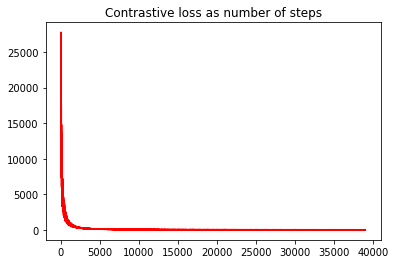

In [28]:
plot.title('Contrastive loss as number of steps')
plot.plot(loss_step, loss2_val, 'r')
plot.show()

## Evaluation for similarity check

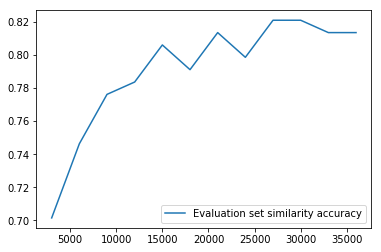

In [29]:
plot.plot(evaluation_step, sim_val, label='Evaluation set similarity accuracy')
plot.legend()
plot.show()

In [31]:
model = CombinedClassifier(num_of_ids=num_of_ids, loss_type="Similarity", similarity_threshold=5)
model.load_weights('cpt/cpt_sim_contrastive_30')
_, sim, ratio = model.test(data_dict['X_eval'], data_dict['y_eval'], similarity_test=True, thresh=best_thresh)
print("Summary for similarity threshold = 30: similarity accuracy = {}, sim diff ratio = {}".format(sim, ratio))

Summary for similarity threshold = 30: similarity accuracy = 0.8208955223880597, sim diff ratio = 0.4579905569553375


### similarity threshold 20: accuracy=82.0%, sim diff ratio=0.45